### This notebook will manipulate and plot the numerical solutions generated using mathematica ###

In [1]:
import sys
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import xarray as xr
import seaborn as sns
import matplotlib
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib
import os
from cmath import sqrt
import matplotlib.gridspec as gridspec
from fractions import Fraction
from PIL import ImageColor

In [2]:
## specify list of experiments. For starters there is just one
# experiments=['meridMode=1_equivalentDepth=12_waveType=Kelvin']
experiments = ['meff=0.10_xiy=1.00_xix=1.00_cp=16.00_k=2.00_model=A']

## specify input directory
dir_in=r'/home/disk/eos7/sressel/research/thesis-work/python/recreating_Ahmed21/'

In [3]:
import glob
exp_name=experiments[0]
fname2=dir_in+exp_name+'/params.mat'
glob.glob(fname2)


['/home/disk/eos7/sressel/research/thesis-work/python/recreating_Ahmed21/meff=0.10_xiy=1.00_xix=1.00_cp=16.00_k=2.00_model=A/params.mat']

In [4]:
test = loadmat(fname2)['Expression1']
test

array([4.62962963e-05, 4.62962963e-05, 2.00000000e-01, 1.00000000e-01,
       5.00000000e+01, 2.27878594e-11, 5.00000000e-04, 9.00000000e-09,
       3.12000000e+04, 6.40000000e+06])

# Routine to read dispersion properties

In [5]:
#define constants
delpg=800*1e2/9.8
Lv=2260e3
cp=1006.

def read_files(exp_name):

    # fname1p=dir_in+exp_name+'/t1_plus_'+exp_name+'.mat'
    # fname1m=dir_in+exp_name+'/t1_minus_'+exp_name+'.mat'
    # fname1=dir_in+exp_name+'/t1_'+exp_name+'.mat'
        
    # fname2=dir_in+exp_name+'/params_'+exp_name+'.mat'
    # fname3=dir_in+exp_name+'/klist_'+exp_name+'.mat'
    # fname4=dir_in+exp_name+'/vars_2D_'+exp_name+'.nc'

    fname1p=dir_in+exp_name+'/t1_plus.mat'
    fname1m=dir_in+exp_name+'/t1_minus.mat'
    fname2=dir_in+exp_name+'/params.mat'
    fname3=dir_in+exp_name+'/klist.mat'
    fname4=dir_in+exp_name+'/vars_2D.nc'

    #extract phase speed
    phase_speed[exp_name]=float(exp_name.split('cp=')[-1].split('_')[0])
        
    #read params
    data2=loadmat(fname2)['Expression1']
    epsq[exp_name],epsa[exp_name],r,meff[exp_name],c,beta,sigma_x[exp_name],sigma_y[exp_name],Ms,Re=data2

    #read wavenumber
    data3=loadmat(fname3)['Expression1']
    klist_read=np.squeeze(np.concatenate((-data3[::-1],data3)))
    
    #compute m using meff and r
    m=(meff[exp_name]+r)/(1+r)
    
    ## Load eigenvalues from the 'plus' solutions###
    
    data1p=loadmat(fname1p)['Expression1']   
    data1p[data1p == 1e10] = np.nan
    ## Make mirror image of solution along k axis and join ###
    ### Warning: imaginary portion of np.nan gives zero, so setting both real and imag. portions explicitly to zero
    data1p_joined=np.concatenate((data1p[::-1,:],data1p),axis=0)
    data1p_joined[np.isnan(data1p_joined)]=np.nan+1J*np.nan

    data_speed_readp=-data1p_joined.imag*Re/(3600.*klist_read[:,None])
    disp_freq_readp=-data1p_joined.imag # frequency 
    disp_growth_readp=data1p_joined.real # growth rates
    
    disp_freq_readp[data_speed_readp<0]=np.nan
    disp_freq_readp[disp_freq_readp<0]=-disp_freq_readp[disp_freq_readp<0]
    disp_growth_readp[data_speed_readp<0]=np.nan
    disp_growthp[exp_name]=disp_growth_readp
    disp_freqp[exp_name]=disp_freq_readp
    
    ## Load eigenvalues from the 'minus' solutions###
    data1m=loadmat(fname1m)['Expression1']
    data1m[data1m == 1e10] = np.nan
    data1m_joined=np.concatenate((data1m[::-1,:],data1m),axis=0).astype(complex)
    data1m_joined[np.isnan(data1m_joined)]=np.nan+1J*np.nan

    data_speed_readm=-data1m_joined.imag*Re/(3600.*klist_read[:,None])
    disp_freq_readm=-data1m_joined.imag
    disp_growth_readm=data1m_joined.real
     
    disp_freq_readm[data_speed_readm<0]=np.nan
    disp_freq_readm[disp_freq_readm<0]=-disp_freq_readm[disp_freq_readm<0]
    disp_growth_readm[data_speed_readm<0]=np.nan     
    disp_growthm[exp_name]=disp_growth_readm
    disp_freqm[exp_name]=disp_freq_readm
        
    ## read wavenumbers
    klist[exp_name]=klist_read
    
    
    # read the eigenfunctions
    # f=Dataset(fname4,'r')
    f = xr.open_dataset(fname4)
    x[exp_name],y[exp_name]=np.squeeze(f.variables['x']),np.squeeze(f.variables['y'])
    u[exp_name]=np.squeeze(f.variables['u'])
    v[exp_name]=np.squeeze(f.variables['v'])
    omega[exp_name]=np.squeeze(f.variables['omega'])
    
    That[exp_name]=np.squeeze(f.variables['That'])/delpg ## convert to K
    qhat[exp_name]=np.squeeze(f.variables['qhat'])/delpg ## convert to K

    pcp[exp_name]=np.squeeze(f.variables['precip'])*3600./delpg ### convert to K/hr
    gamma_qT[exp_name]=qhat[exp_name].max()/That[exp_name].max()
                

        
    f.close()
    
    return c,beta,r,Ms,Re
    

In [6]:
### declare dicts 
epsq={}
epsa={}
meff={}
sigma_x={}
sigma_y={}
phase_speed={}

disp_growthp={}
disp_freqp={}

disp_growthm={}
disp_freqm={}

klist={}

u={}
v={}
omega={}
That={}
qhat={}
pcp={}
x={}
y={}
gamma_qT={}


### read files ###

for i in experiments:#+experiments_tauq:
    print(i)
    c,beta,r,Ms,Re=read_files(i)


meff=0.10_xiy=1.00_xix=1.00_cp=16.00_k=2.00_model=A


In [7]:
fname2=dir_in+exp_name+'/params.mat'
fname3=dir_in+exp_name+'/klist.mat'
fname4=dir_in+exp_name+'/vars_2D.nc'

#extract phase speed
phase_speed[exp_name]=float(exp_name.split('cp=')[-1].split('_')[0])

#read params
data2=loadmat(fname2)['Expression1']

data2

array([4.62962963e-05, 4.62962963e-05, 2.00000000e-01, 1.00000000e-01,
       5.00000000e+01, 2.27878594e-11, 5.00000000e-04, 9.00000000e-09,
       3.12000000e+04, 6.40000000e+06])

In [48]:
cmap=plt.get_cmap('gist_earth')

### Plot the dispersion relationships (Fig. 2 in Ahmed 2021)

In [8]:
colors={experiments[0]:'orange'}

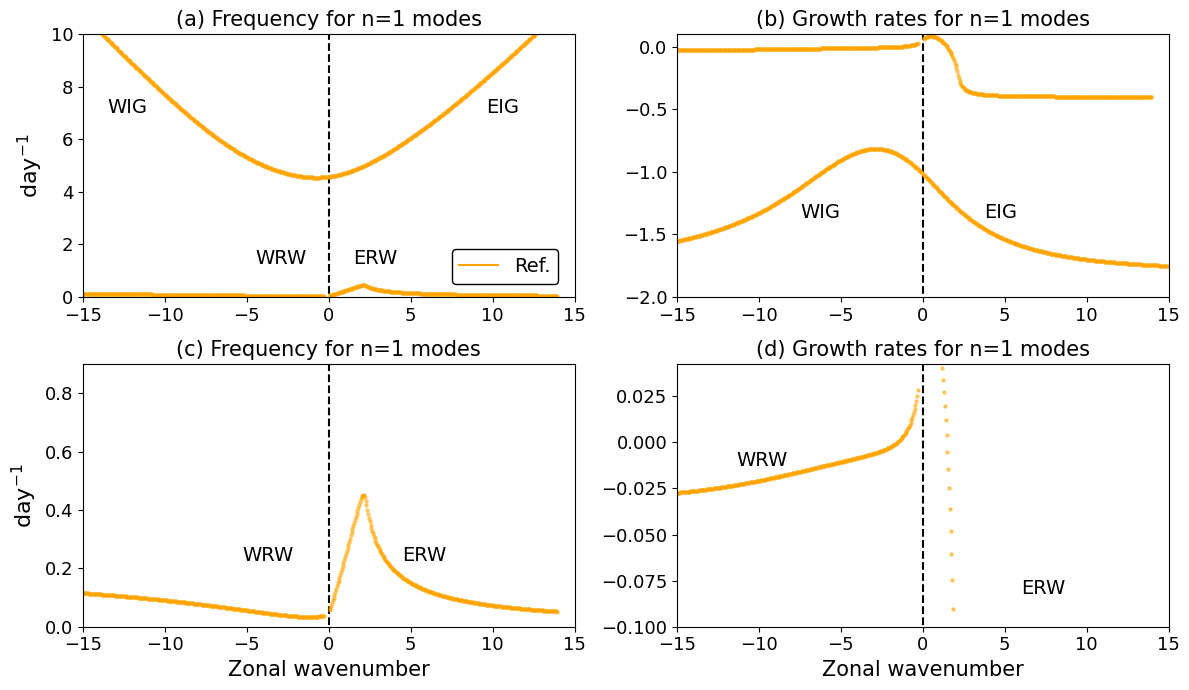

In [9]:
ln={}

fig,axx=plt.subplots(2,2,figsize=(12,7))

for no,exp_name in enumerate(experiments):

    ax=axx[0,0]
    for i in range(disp_freqp[exp_name].shape[1]):
        freqp=np.copy(disp_freqp[exp_name][:,i])
        grp=np.copy(disp_growthp[exp_name][:,i])
        speed=freqp*Re/(3600.0*klist[exp_name])
        ax.scatter(klist[exp_name],freqp*24,s=5,c=colors[exp_name],alpha=0.5)
        freqm=np.copy(disp_freqm[exp_name][:,i])

        ax.scatter(klist[exp_name],freqm*24,s=5,c=colors[exp_name],alpha=0.5)
    

        if no==0:
            ln[exp_name] = mlines.Line2D([], [], color=colors[exp_name], linestyle='-', markersize=10, 
                                         label='Ref.')
            
            
    ax.vlines(0,0.5*24,-0.9,linestyle='--',zorder=-1,color='black')
    
    if no==0:
        ax.text(0.05,0.7,'WIG',transform=ax.transAxes,fontsize=14)
        ax.text(0.82,0.7,'EIG',transform=ax.transAxes,fontsize=14)
        ax.text(0.35,0.125,'WRW',transform=ax.transAxes,fontsize=14)
        ax.text(0.55,0.125,'ERW',transform=ax.transAxes,fontsize=14)

    ax.tick_params(which='both',labelsize=13)
    ax.set_title('(a) Frequency for n=1 modes',fontsize=15)
    ax.set_ylim(bottom=0.0,top=10)
    ax.set_xlim(-15,15.)
    ax.set_ylabel('$\mathrm{day}^{-1}$',fontsize=16)
    
            
    ax=axx[1,0]
    for i in range(disp_freqp[exp_name].shape[1]):
        freqp=np.copy(disp_freqp[exp_name][:,i])
        grp=np.copy(disp_growthp[exp_name][:,i])
        speed=freqp*Re/(3600.0*klist[exp_name])
        ax.scatter(klist[exp_name],freqp*24,s=5,c=colors[exp_name],alpha=0.5)
        
        freqm=np.copy(disp_freqm[exp_name][:,i])
        speed=freqm*Re/(3600.0*klist[exp_name])
        ax.scatter(klist[exp_name],freqm*24,s=5,c=colors[exp_name],alpha=0.5)
    

        if no==0:
            ln[exp_name] = mlines.Line2D([], [], color=colors[exp_name], linestyle='-', markersize=10, 
                                         label='Ref.')
                
        
    ax.vlines(0,0.5*24,-0.9,linestyle='--',zorder=-1,color='black')
    if no==0:
        ax.text(0.325,0.25,'WRW',transform=ax.transAxes,fontsize=14)
        ax.text(0.65,0.25,'ERW',transform=ax.transAxes,fontsize=14)

    ax.tick_params(which='both',labelsize=13)
    ax.set_title('(c) Frequency for n=1 modes',fontsize=15)
    ax.set_ylim(bottom=0.0,top=0.9)
    ax.set_xlim(-15,15.)
    ax.set_xlabel('Zonal wavenumber',fontsize=15)
    ax.set_ylabel('$\mathrm{day}^{-1}$',fontsize=16)    
    
    ax=axx[0,1]
    for i in range(disp_growthp[exp_name].shape[1]):
        freqp=np.copy(disp_freqp[exp_name][:,i])
        grp=np.copy(disp_growthp[exp_name][:,i])
        speed=freqp/(klist[exp_name])
        ax.scatter(klist[exp_name],grp*24,s=5,c=colors[exp_name],alpha=0.5)
        ax.scatter(klist[exp_name],disp_growthm[exp_name][:,i]*24.,s=5,c=colors[exp_name],alpha=0.5)

    ax.tick_params(which='both',labelsize=13)
    ax.set_title('(b) Growth rates for n=1 modes',fontsize=15)
    ax.set_ylim(top=0.1,bottom=-2)
    ax.set_xlim(-15.,15.)
    if no==0:
        ax.text(0.25,0.3,'WIG',transform=ax.transAxes,fontsize=14)
        ax.text(0.625,0.3,'EIG',transform=ax.transAxes,fontsize=14)
    
    ax.vlines(0,0.5*24,-5.0,linestyle='--',zorder=-1,color='black')
    
    ax=axx[1,1]
    for i in range(disp_growthp[exp_name].shape[1]):
        freqp=np.copy(disp_freqp[exp_name][:,i])
        grp=np.copy(disp_growthp[exp_name][:,i])
        speed=freqp/(klist[exp_name])
        ax.scatter(klist[exp_name],grp*24,s=5,c=colors[exp_name],alpha=0.5)
        ax.scatter(klist[exp_name],disp_growthm[exp_name][:,i]*24.,s=5,c=colors[exp_name],alpha=0.5)

    
    if no==0:
        ax.text(0.12,0.61,'WRW',transform=ax.transAxes,fontsize=14)
        ax.text(0.7,0.125,'ERW',transform=ax.transAxes,fontsize=14)

    ax.tick_params(which='both',labelsize=13)
    ax.set_title('(d) Growth rates for n=1 modes',fontsize=15)
    ax.set_ylim(top=0.0425,bottom=-0.1)
    ax.set_xlim(-15.,15.)
    ax.set_xlabel('Zonal wavenumber',fontsize=15)
    
    ax.vlines(0,0.5*24,-5.0,linestyle='--',zorder=-5,color='black')

    
    plt.subplots_adjust(top=0.8)
    

leg_names=[]
leg_labels=[]
for n,exp_name in enumerate(experiments[:2]):
    leg_names.append(ln[exp_name])
    leg_labels.append(exp_name)
    

leg=axx[0,0].legend(handles=leg_names,ncol=1,fontsize=14.0,
                  loc=(0.75,0.05))

frame=leg.get_frame()
frame.set_edgecolor('black')
frame.set_facecolor('white')
frame.set_alpha(1)

plt.tight_layout()
SAVE=False
if SAVE:
    plt.savefig('./Fig_wavenumber_frequency.pdf',
               format='pdf',dpi=125,bbox_inches='tight')

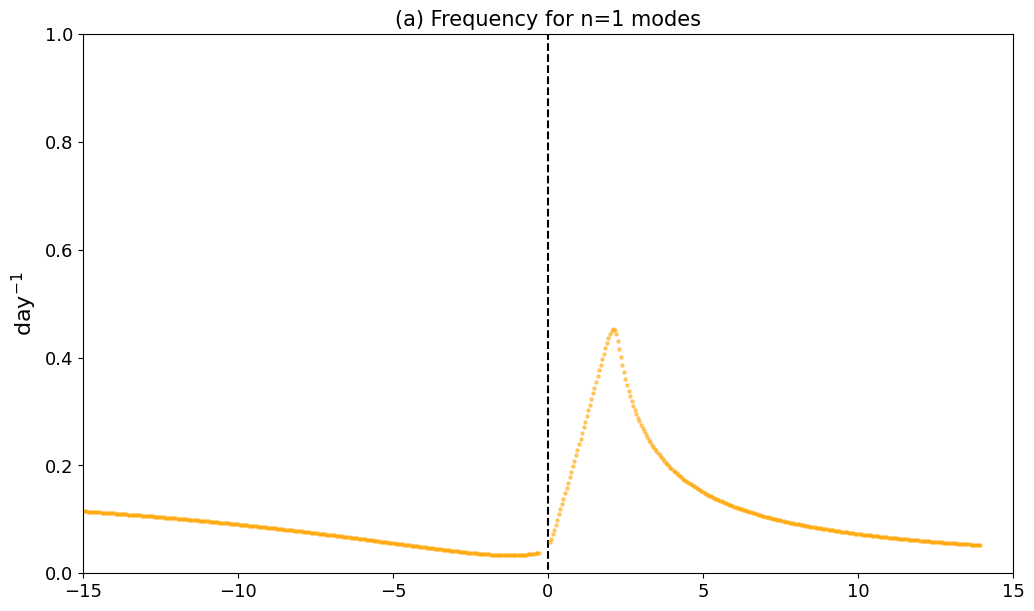

In [10]:
fig,ax=plt.subplots(1,1,figsize=(12,7))

for no,exp_name in enumerate(experiments):
    for i in range(disp_freqp[exp_name].shape[1]):
        freqp=np.copy(disp_freqp[exp_name][:,i])
        ax.scatter(klist[exp_name],freqp*24,s=5,c=colors[exp_name],alpha=0.5)
        freqm=np.copy(disp_freqm[exp_name][:,i])
        ax.scatter(klist[exp_name],freqm*24,s=5,c=colors[exp_name],alpha=0.5)
            
    ax.vlines(0,0.5*24,-0.9,linestyle='--',zorder=-1,color='black')

    ax.tick_params(which='both',labelsize=13)
    ax.set_title('(a) Frequency for n=1 modes',fontsize=15)
    ax.set_ylim(bottom=0.0,top=10)
    ax.set_xlim(-15,15.)
    ax.set_ylim(0, 1)
    ax.set_ylabel('$\mathrm{day}^{-1}$',fontsize=16)
    

In [85]:
disp_freqp[exp_name]

array([[       nan, 0.21609387, 0.00462828, ...,        nan,        nan,
               nan],
       [       nan, 0.21372773, 0.00462005, ...,        nan,        nan,
               nan],
       [       nan, 0.21137641, 0.00461179, ...,        nan,        nan,
               nan],
       ...,
       [0.27720862,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.27908645,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.2809681 ,        nan,        nan, ...,        nan,        nan,
               nan]])

### Plot the meridional structure (Fig. 4 in Ahmed 2021) ###

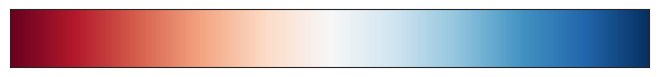

In [2]:
##choose colormap
pal=sns.choose_colorbrewer_palette('diverging',as_cmap=True)

In [ ]:
## Set ranges for plotting ##
vel_range=np.arange(-3.0,3.5,0.5)*2.0
omega_range=vel_range*1e-6
that_range=np.arange(-0.15,0.2,0.05)*1e0
# qhat_range=np.arange(-2.0,2.2,0.2)*0.5*delpg/cp
qhat_range=np.arange(-6.0,6.5,0.5) ### in mm

# pcp_range=np.arange(-0.05,0.055,0.005)
pcp_range=np.arange(-5.0,5.5,0.5)

In [ ]:
def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)


In [ ]:
ylocs=np.arange(-30,35.0,2.5)*111

In [ ]:
## functions to transform x and y to lat and lon values

def xtolon(x, pos, offset=180):
    'The two args are the value and tick position'
    val=(x*360/(2*np.pi*Re*1e-3)-offset)
    val=np.round(val/10)*10 ## rounding to convert 59W to 60W
    if val<180 and val>0:
        return '$%d\mathrm{ E}$' % (val)
    elif val<0:
        return '$%d\mathrm{ W}$' % (abs(val))
    else:
        return '$%d$' % (val)

def ytolat(y, pos):
    'The two args are the value and tick position'
    if y>0:
        return '${%d }\mathrm{ N}$' % (y/111) 
    elif y<0: 
        return '${%d }\mathrm{ S}$' % (y/111)
    elif y==0:
        return '${%d }$' % (y/111)


## The next cell re-produces Fig. 4 in Ahmed 2021

exp_name=experiments[0]

scale=5/u[exp_name].max()  # scale structures such that max zonal wind is 5 m/s
u_norm=-np.copy(u[exp_name]*scale)
v_norm=-np.copy(v[exp_name]*scale)
# u_norm[:]=0.0
xarr=x[exp_name]*Re*1e-3
yarr=y[exp_name]*1e-3
X, Y = np.meshgrid(xarr, yarr,indexing='ij')
xiint=1
yiint=32

pcp_scale=24*delpg*cp/Lv ## convert to mm/d

xlims=[20e3,39e3]
ylims=[-3.5e3,3.5e3]
scale_vec=0.0025*0.25
# quiverkey_length=5.00/3e2

fig,axx=plt.subplots(1,2,figsize=(14.5,4.0))
# plt.suptitle('%s Run'%(exp_name),fontsize=15)


ax=axx[0]

CS=ax.contour(x[exp_name]*1e-3*Re,y[exp_name]*1e-3,That[exp_name].T*scale,
              levels=that_range*scale,extend='both',colors='black',linewidth=3)


CT=ax.contourf(x[exp_name]*1e-3*Re,y[exp_name]*1e-3,pcp[exp_name].T*pcp_scale*scale,
           levels=pcp_range*scale,extend='both',cmap=pal,inline=True,fontsize=12)

ax.clabel(CS, CS.levels, inline=True, fmt='%.2f', fontsize=10)


ax.set_title('(a) ERW precipitation and temperature',fontsize=15)
ax.tick_params(which='both',labelsize=13)

ax.set_xlim(xlims)
ax.set_ylim(ylims)

xlocs=np.arange(0,390,30)*2*np.pi*Re*1e-3/(360)
xmajorLocator = matplotlib.ticker.FixedLocator(locs=xlocs) 
xmajorFormatter = matplotlib.ticker.FuncFormatter(xtolon)

ax.xaxis.set_major_locator( xmajorLocator )
ax.xaxis.set_major_formatter( xmajorFormatter )

ylocs=np.arange(-30,40.0,10.0)*111
ymajorLocator = matplotlib.ticker.FixedLocator(locs=ylocs) 
ymajorFormatter = matplotlib.ticker.FuncFormatter(ytolat)

ax.yaxis.set_major_locator( ymajorLocator )
ax.yaxis.set_major_formatter( ymajorFormatter )


axpos = ax.get_position()
pos_x = axpos.x0+0.12*axpos.width #+ 0.025# + 0.25*axpos.width
pos_y = axpos.y0-0.2*axpos.height
cax_width = axpos.width*0.75
cax_height = 0.025#axpos.height

pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
CB=plt.colorbar(CT, cax=pos_cax,label='mm $\mathrm{d}^{-1}$',
                orientation='horizontal',format="%.1f",
               ticks=matplotlib.ticker.MultipleLocator(0.5))
text=CB.ax.xaxis.label

font = matplotlib.font_manager.FontProperties(family='Arial',  size=14)

text.set_font_properties(font)


pos_cax.yaxis.label.set_font_properties(font)
pos_cax.tick_params(which='both',labelsize=12.)


ax=axx[1]

CT=ax.contourf(x[exp_name]*1e-3*Re,y[exp_name]*1e-3,qhat[exp_name].T*scale*delpg*cp/Lv,
               levels=qhat_range*scale*0.5,extend='both',cmap=pal)


CS=ax.contour(x[exp_name]*1e-3*Re,y[exp_name]*1e-3,omega[exp_name].T*1e6*scale,colors='magenta',
               levels=np.delete(vel_range*scale,np.where(vel_range==0)),extend='both')


ax.clabel(CS, CS.levels, inline=True, fmt='%.2f', fontsize=10)


q=ax.quiver(X[::xiint,::yiint],Y[::xiint,::yiint],u_norm[::xiint,::yiint],
            v_norm[::xiint,::yiint],angles='uv',
            scale_units='xy',units='xy',
            scale=scale_vec,pivot='middle',alpha=1.0,color='black',
           headwidth=6,headlength=7,headaxislength=4.5,zorder=10)

ax.quiverkey(q, X=0.935, Y=-.2, U=1.0,
             label='1 $\mathrm{ms}^{-1}$',
             labelpos='S',color='black',fontproperties={'size': '13'})


ax.set_title('(b) ERW moisture, divergence and winds',fontsize=15)
ax.tick_params(which='both',labelsize=13)

ax.set_xlim(xlims)
ax.set_ylim(ylims)

xlocs=np.arange(0,390,30)*2*np.pi*Re*1e-3/(360)
xmajorLocator = matplotlib.ticker.FixedLocator(locs=xlocs) 
xmajorFormatter = matplotlib.ticker.FuncFormatter(xtolon)

ax.xaxis.set_major_locator( xmajorLocator )
ax.xaxis.set_major_formatter( xmajorFormatter )

ylocs=np.arange(-30,40.0,10.0)*111
ymajorLocator = matplotlib.ticker.FixedLocator(locs=ylocs) 
ymajorFormatter = matplotlib.ticker.FuncFormatter(ytolat)

ax.yaxis.set_major_locator( ymajorLocator )
ax.yaxis.set_major_formatter( ymajorFormatter )




axpos = ax.get_position()
pos_x = axpos.x0+0.05*axpos.width #+ 0.025# + 0.25*axpos.width
pos_y = axpos.y0-0.2*axpos.height
cax_width = axpos.width*0.75
cax_height = 0.025#axpos.height

pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
CB=plt.colorbar(CT, cax=pos_cax,label='mm',orientation='horizontal',format="%.1f",
               ticks=matplotlib.ticker.MultipleLocator(0.2))
text=CB.ax.xaxis.label

font = matplotlib.font_manager.FontProperties(family='Arial',  size=14)

text.set_font_properties(font)


pos_cax.yaxis.label.set_font_properties(font)
pos_cax.tick_params(which='both',labelsize=12.)

SAVE=False
if SAVE:
    plt.savefig('./Fig_merid_struct_ERW_waveno2.pdf',
               format='pdf',dpi=125,bbox_inches='tight')